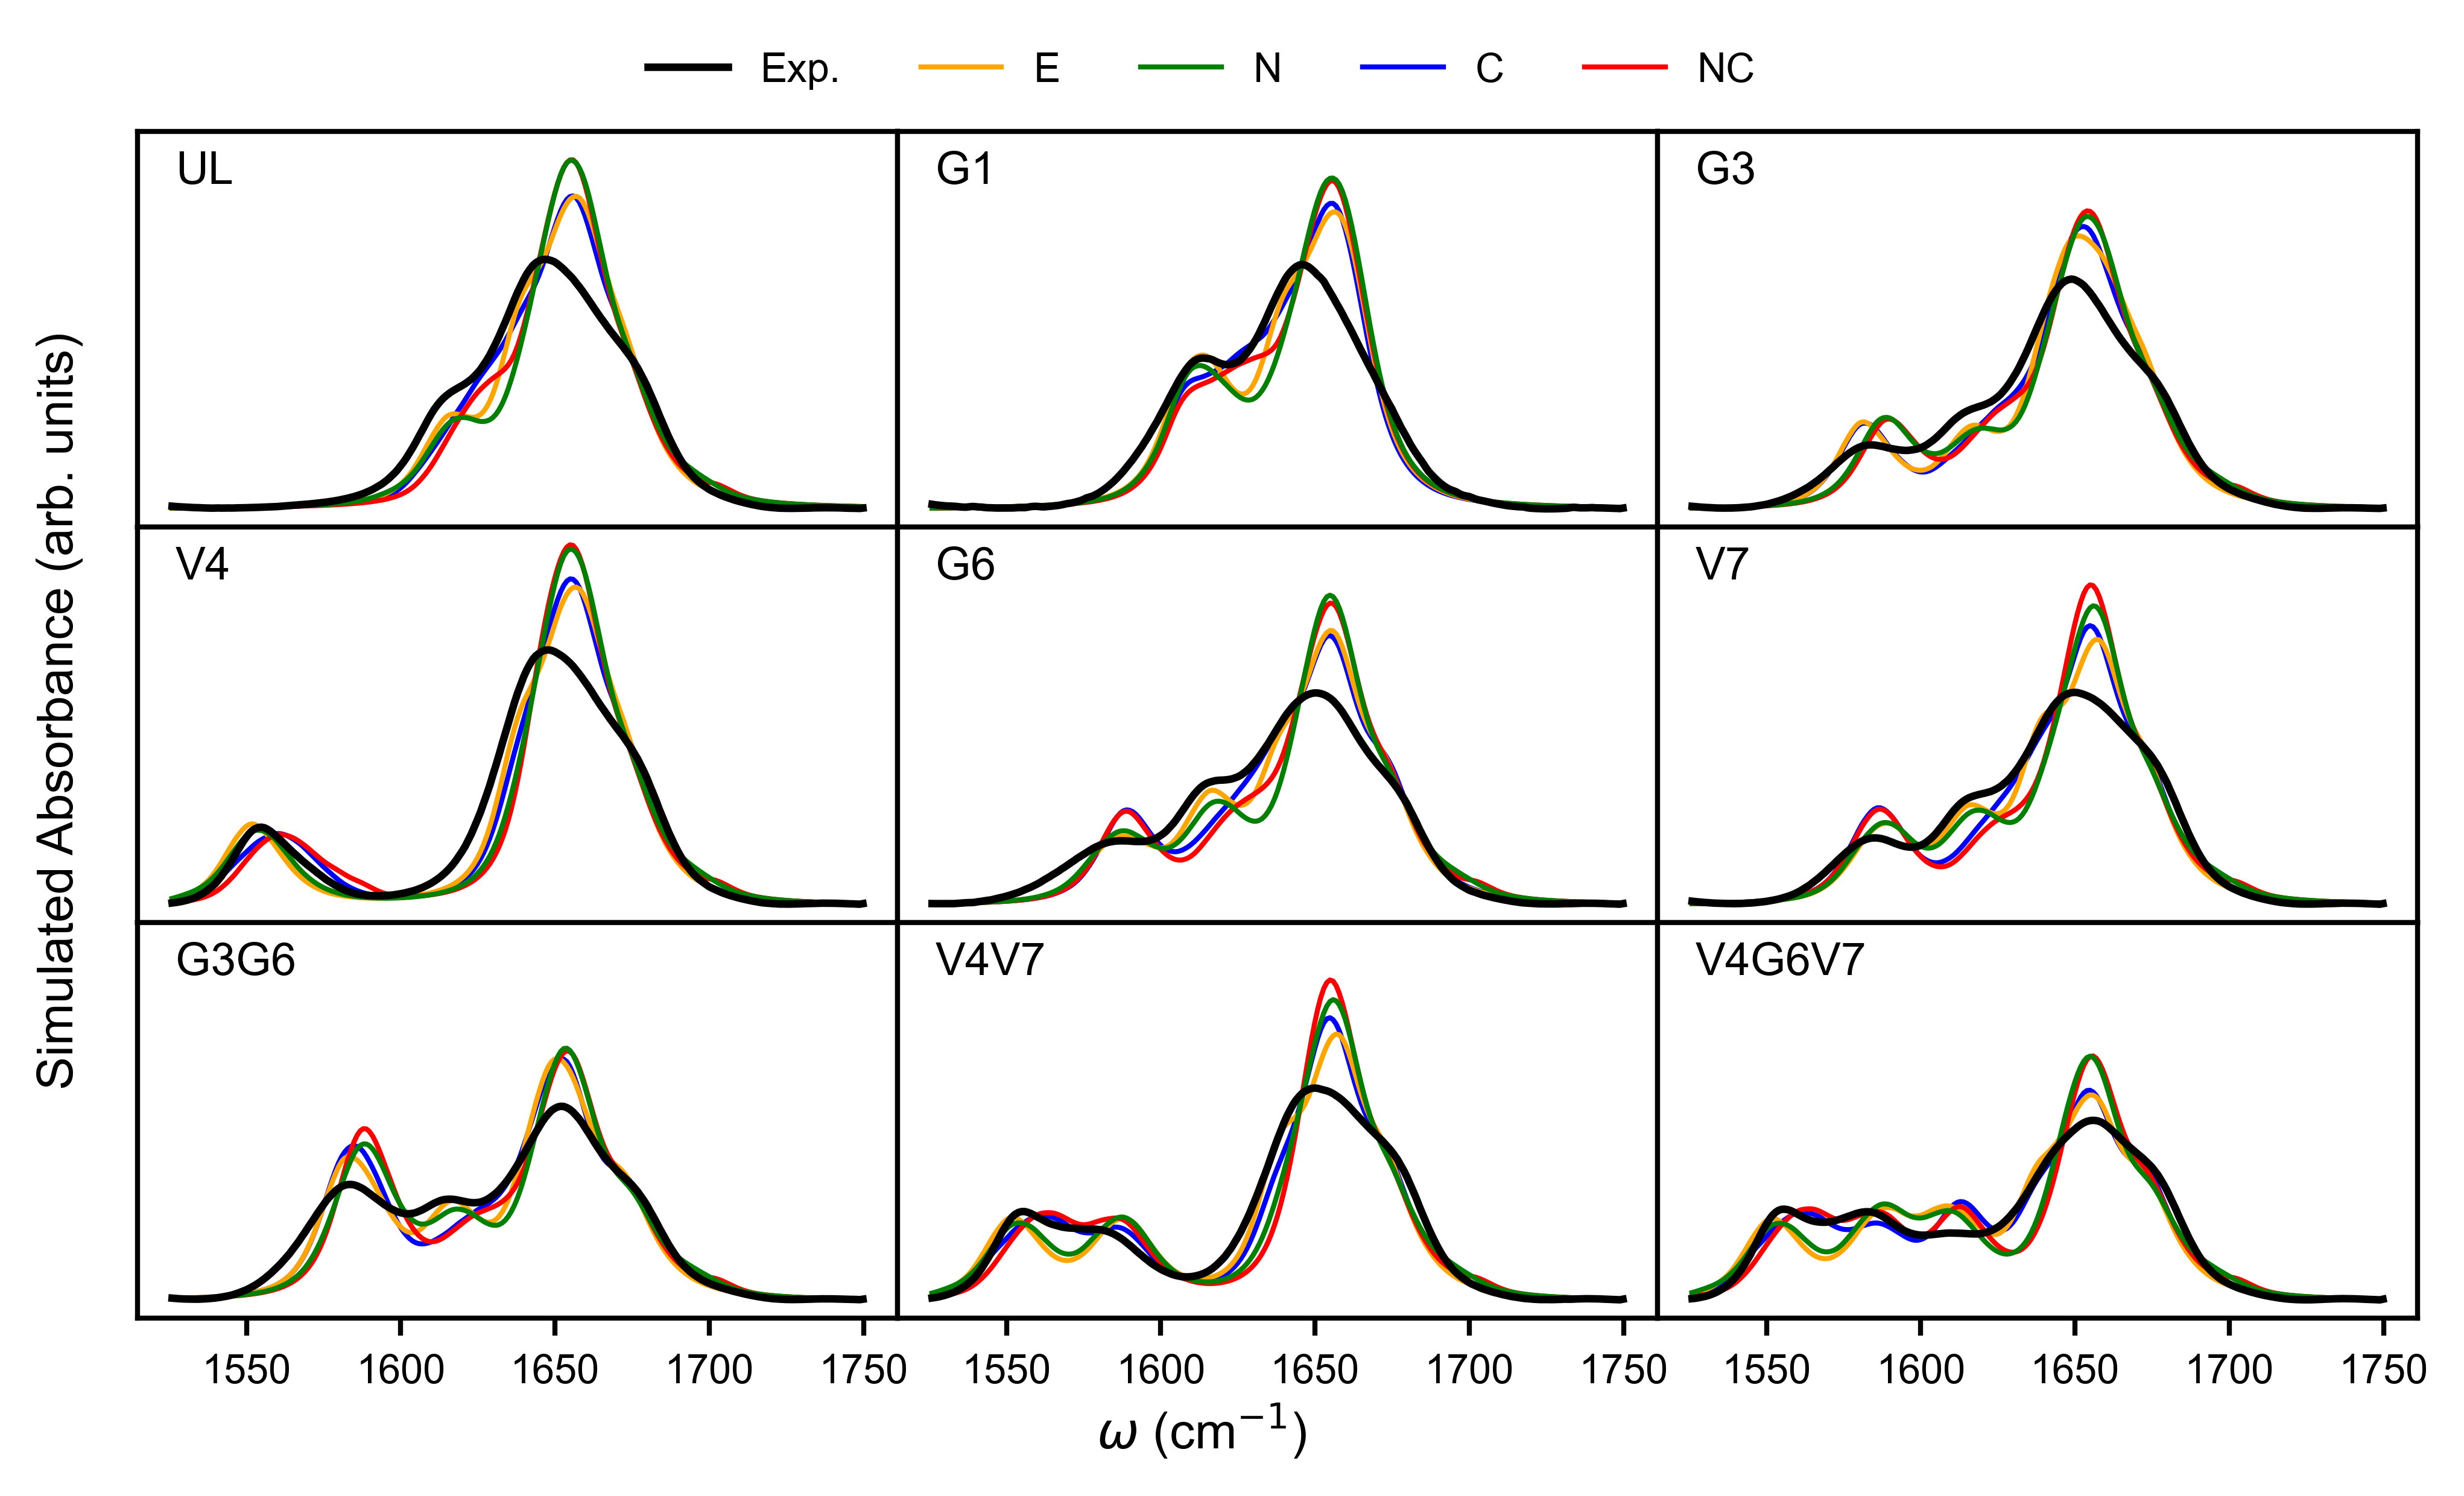

In [1]:
### PLOTS STATE SPECTRA (FIG 7) IN MAIN TEXT ###
### 1 Aug 2025 ###

import numpy as np                    
import matplotlib.pyplot as plt       
from pathlib import Path             

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# File paths - Path objects handle OS differences automatically
BASE_DIR = Path('../data')
WAVENUMBERS_FILE = BASE_DIR / 'waxis.txt'                          # Shape: (225,)
EXP_DIR = BASE_DIR / 'exp_data' / 'processed_FTIRs'               
SIM_DIR = BASE_DIR / 'sim_data' / 'sim_spec'                     
PROP_DIR = BASE_DIR / 'prop_array'                                 

# Simulation parameters
FORCE_FIELD = 'CHARMM27_TIP3P'     
MAP_TYPE = 'DC1Fnew'                

ISOTOPES = ['WT', 'G3+', 'G5+', 'V1', 'G3', 'V4', 'G5+G3', 'V1V4', 'V1G3V4']  

# Mapping from isotope codes to plot labels
ISOTOPE_LABELS = {
    'WT': 'UL', 'G3+': 'G1', 'G5+': 'G3', 'V1': 'V4', 'G3': 'G6', 'V4': 'V7',
    'G5+G3': 'G3G6', 'V1V4': 'V4V7', 'V1G3V4': 'V4G6V7'
}

# Mapping from isotope codes to filename components for experiment
ISOTOPE_FILE_MAP = {
    'WT': 'WT', 'G3+': 'G3dag', 'G5+': 'G5dag', 'V1': 'V1', 'G3': 'G3',
    'V4': 'V4', 'G5+G3': 'G5dagG3', 'V1V4': 'V1V4', 'V1G3V4': 'V1G3V4'
}

STATE_KEYS = ['C', 'E', 'NC', 'N'] 
STATE_COLORS = {'C': 'blue', 'E': 'orange', 'NC': 'red', 'N': 'green', 'Exp.': 'black'}

# Analysis parameters
WAVENUMBER_RANGE = (1525, 1750)     # Tuple: (min_wavenumber, max_wavenumber) in cm^-1
PURITY_THRESHOLD = 0.95              # Float: minimum proportion to consider trajectory "pure"

# Plotting specifications
FIGURE_SIZE = (7, 4)                 
DPI = 600                           

# -----------------------------------------------------------------------------
# DATA LOADING FUNCTIONS
# -----------------------------------------------------------------------------

def load_wavenumbers():
    """
    Load and trim wavenumber axis from file.
    
    Returns:
        np.ndarray: Wavenumber values in specified range, shape: (225,)
                   225 points for 1525-1750 cm^-1 range
    """
    wavenumbers = np.loadtxt(WAVENUMBERS_FILE)  
    in_range = (wavenumbers >= WAVENUMBER_RANGE[0]) & (wavenumbers <= WAVENUMBER_RANGE[1])  
    return wavenumbers[in_range]  # Shape: (225,)

def load_experimental(isotope, wavenumbers):
    """
    Load and normalize single experimental spectrum for given isotope.
    
    Args:
        isotope (str): Isotope identifier (e.g., 'WT', 'G3+')
        wavenumbers (np.ndarray): Wavenumber axis, shape: (225,)
        
    Returns:
        np.ndarray: Normalized experimental spectrum, shape: (225,)
    """
    # Build filename using isotope mapping
    filename = f'GVGn1_{ISOTOPE_FILE_MAP[isotope]}_50mgmL_phos_150mM_pH1_basecorr_processed.npy'
    filepath = EXP_DIR / filename
    
    # Load spectrum from .npy file
    spectrum = np.load(filepath)  # Shape: (225,) 
    
    # Normalize by integrated area and return
    return normalize_by_area(spectrum, wavenumbers)  # Shape: (225,)

def load_simulated(isotope, wavenumbers):
    """
    Load and normalize all simulated spectra for given isotope.
    
    Args:
        isotope (str): Isotope identifier
        wavenumbers (np.ndarray): Wavenumber axis, shape: (225,)
        
    Returns:
        np.ndarray: All normalized simulated spectra, shape: (5000, 225)
                   5000 trajectories, each with 225 wavenumber points
    """
    # Build filename for this isotope's simulated data
    filename = f'{MAP_TYPE}_{FORCE_FIELD}_{isotope}_ftir.npy'
    filepath = SIM_DIR / FORCE_FIELD / filename
    
    # Load raw simulated spectra
    raw_spectra = np.load(filepath)  # Shape: (5000, 225) - 5000 trajectories
    
    # Baseline correction: subtract minimum value from each trajectory
    min_values = np.min(raw_spectra, axis=1)        # Shape: (5000,) - min per trajectory
    min_values_expanded = min_values[:, np.newaxis]  # Shape: (5000, 1) - for broadcasting
    corrected = raw_spectra - min_values_expanded    # Shape: (5000, 225) - baseline corrected
    
    # Normalize each trajectory by its area using list comprehension
    normalized_list = [normalize_by_area(spectrum, wavenumbers) for spectrum in corrected]  # List of 5000 arrays
    
    # Convert list back to numpy array
    return np.array(normalized_list)  # Shape: (5000, 225)

def load_proportions():
    """
    Load state proportions array showing time spent in each state per trajectory.
    
    Returns:
        np.ndarray: State proportions, shape: (5000, 4)
                   5000 trajectories, 4 states where each row sums to 1.0
                   Column order matches STATE_KEYS: ['C', 'E', 'NC', 'N']
    """
    filename = f'proportions_array_0100ps_{FORCE_FIELD}_PAPER.npy'
    filepath = PROP_DIR / FORCE_FIELD / filename
    
    # Load proportions array
    proportions = np.load(filepath)  # Shape: (5000, 4)
    # Each row: [proportion_C, proportion_E, proportion_NC, proportion_N]
    # Values between 0-1, each row sums to 1.0
    
    return proportions

# -----------------------------------------------------------------------------
# ANALYSIS FUNCTIONS
# -----------------------------------------------------------------------------

def normalize_by_area(spectrum, wavenumbers):
    """
    Normalize spectrum by its integrated area using trapezoidal rule.
    
    Args:
        spectrum (np.ndarray): Raw spectrum intensities, shape: (225,)
        wavenumbers (np.ndarray): Wavenumber axis, shape: (225,)
        
    Returns:
        np.ndarray: Area-normalized spectrum, shape: (225,)
    """
    # Calculate integrated area using trapezoidal rule
    area = np.trapz(spectrum, x=wavenumbers)  
    
    return spectrum / area  # Shape: (225,) - each point divided by total area

def compute_state_averages(simulated_spectra, proportions, wavenumbers):
    """
    Compute average spectra for pure-state trajectories (>95% in single state).
    
    Args:
        simulated_spectra (np.ndarray): All simulated spectra, shape: (5000, 225)
        proportions (np.ndarray): State proportions per trajectory, shape: (5000, 4)
        wavenumbers (np.ndarray): Wavenumber axis, shape: (225,)
        
    Returns:
        dict: State-averaged spectra, keys are state names, values are arrays of shape (225,)
              Example: {'C': array(225,), 'E': array(225,), 'NC': array(225,), 'N': array(225,)}
    """
    averages = {}  # Empty dict to store results
    
    # Loop through each state with its index
    for idx, state in enumerate(STATE_KEYS):  # idx: 0,1,2,3 for 'C','E','NC','N'
        
        # Find trajectories that are >95% pure in this state
        state_proportions = proportions[:, idx]           # Shape: (5000,) - proportions for this state
        mask = state_proportions > PURITY_THRESHOLD       # Shape: (5000,) - boolean array
        
        # Example for state 'C' (idx=0):
        # proportions[:, 0] = [0.05, 0.97, 0.30, 0.98, 0.02, ...]  # C proportions for all 5000 trajectories
        # mask = [False, True, False, True, False, ...]              
        
        pure_spectra = simulated_spectra[mask]  # Shape: (n_pure, 225) - only pure C trajectories
        
        # Average across pure segments (axis=0 averages rows)
        mean_spectrum = np.mean(pure_spectra, axis=0)  # Shape: (225,) 
        
        # Normalize the averaged spectrum
        averages[state] = normalize_by_area(mean_spectrum, wavenumbers)  # Shape: (225,)
    
    return averages  # Dict with 4 entries, each value has shape (225,)

# -----------------------------------------------------------------------------
# PLOTTING FUNCTIONS
# -----------------------------------------------------------------------------

def set_plot_style():
    """Set consistent plot style for ACS publication figures."""
    plt.rcParams.update({
        # Font settings - Arial (PC) or Helvetica (Mac) as per ACS
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'font.size': 10,  # Will be readable at 5pt when reduced to column width
        
        # Line widths - minimum 1 pt as per ACS
        'lines.linewidth': 1.0,
        'axes.linewidth': 1.0,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'patch.linewidth': 1.0,
        'grid.linewidth': 1.0,
        
        # Font sizes - accounting for reduction
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # DPI settings
        'figure.dpi': 600
    })


def plot_isotope_spectra(ax, wavenumbers, state_spectra, experimental_spectrum, label):
    """
    Plot spectra for a single isotope on given axes.
    
    Args:
        ax (matplotlib.axes.Axes): Subplot axes to plot on
        wavenumbers (np.ndarray): X-axis values, shape: (225,)
        state_spectra (dict): State-averaged spectra, 4 entries with values of shape (225,)
        experimental_spectrum (np.ndarray): Experimental data, shape: (225,)
        label (str): Text label for this isotope (e.g., 'UL', 'G1')
    """
    # Plot each state's averaged spectrum
    for state in STATE_KEYS:  # Loop through ['C', 'E', 'NC', 'N']
        spectrum = state_spectra[state]  # Shape: (225,)
        color = STATE_COLORS[state]      # Get color for this state
        
        # Plot spectrum line
        ax.plot(wavenumbers, spectrum,   # X: (225,), Y: (225,)
                color=color, label=state, lw=1)  # lw = line width
    
    # Plot experimental spectrum with thicker line
    ax.plot(wavenumbers, experimental_spectrum,  # X: (225,), Y: (225,)
            color=STATE_COLORS['Exp.'], lw=1.5, label='Exp.')
    
    # Add isotope label in top-left corner
    ax.text(0.05, 0.95, label,           # Position in axes coordinates (0-1)
            transform=ax.transAxes,       # Use axes coordinates instead of data coordinates
            ha='left', va='top', fontsize=9,  # Horizontal/vertical alignment
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=1.5))  # White background box
    
    # Remove y-axis tick labels (keep ticks but hide numbers)
    ax.set_yticks([])

def create_figure(wavenumbers, proportions):
    """
    Create complete 3x3 figure with all isotope spectra.
    
    Args:
        wavenumbers (np.ndarray): Wavenumber axis, shape: (225,)
        proportions (np.ndarray): State proportions, shape: (5000, 4)
    """
    # Create 3x3 subplot grid
    fig, axes = plt.subplots(3, 3,              
                           figsize=FIGURE_SIZE,  
                           sharex=True,          
                           sharey=True,          
                           dpi=DPI)              

    # Flatten 2D axes array to 1D for easier indexing
    axes = axes.ravel()  # Shape: (9,) - linear array of 9 subplot axes

    # Loop through each isotope with its position index
    for idx, isotope in enumerate(ISOTOPES):  # idx: 0-8, isotope: 'WT', 'G3+', etc.
        ax = axes[idx]  # Get the subplot for this isotope
        
        # Load experimental data for this isotope
        experimental_spectrum = load_experimental(isotope, wavenumbers)  # Shape: (225,)
        
        # Load all simulated trajectories for this isotope
        simulated_spectra = load_simulated(isotope, wavenumbers)  # Shape: (5000, 225)
        
        # Compute state-averaged spectra from pure trajectories
        state_average_spectra = compute_state_averages(simulated_spectra, proportions, wavenumbers)
        # Returns: {'C': array(225,), 'E': array(225,), 'NC': array(225,), 'N': array(225,)}
        
        # Plot all spectra for this isotope
        plot_isotope_spectra(ax, wavenumbers, state_average_spectra, 
                           experimental_spectrum, ISOTOPE_LABELS[isotope])
            

    # Create legend using first subplot's handles and labels
    handles, labels = axes[0].get_legend_handles_labels()  
    
    # Reorder legend entries for better presentation
    desired_order = ['Exp.', 'E', 'N', 'C', 'NC']  # Put experimental first, then states
    handle_map = dict(zip(labels, handles))         # Create label->handle mapping
    
    # Build ordered lists for legend
    ordered_handles = [handle_map[label] for label in desired_order if label in handle_map]
    ordered_labels = [label for label in desired_order if label in handle_map]
    
    # Add legend at top of figure
    fig.legend(ordered_handles, ordered_labels,
               loc='upper center',                    
               bbox_to_anchor=(0.5, 0.98),          
               ncol=5,                               
               frameon=False,                        
               fontsize=8)                           

    # Add axis labels to entire figure
    fig.text(0.04, 0.5,                             
             'Simulated Absorbance (arb. units)',    
             va='center', rotation='vertical',        
             fontsize=10)
    
    fig.text(0.5, -0.01,                            
             r'$\omega$ (cm$^{-1}$)',               
             ha='center', fontsize=10)              

    # Format tick labels - only show x-labels on bottom row
    for idx in range(6):  # Top and middle rows (indices 0-5)
        axes[idx].tick_params(bottom=False, labelbottom=False)  # Hide x-tick labels
    
    for idx in range(6, 9):  # Bottom row (indices 6-8)
        axes[idx].tick_params(labelsize=8)  # Show x-tick labels with small font

    # Adjust subplot spacing
    plt.subplots_adjust(left=0.08,    
                       bottom=0.08,   
                       right=0.98,    
                       top=0.9,       
                       wspace=0,      
                       hspace=0)      
    
    # Display the figure
    plt.show()

# -----------------------------------------------------------------------------
# MAIN EXECUTION
# -----------------------------------------------------------------------------

def main():
    """Main function to generate the complete spectroscopy plot."""
    # Set plotting style
    set_plot_style()
    
    # Load data
    wavenumbers = load_wavenumbers()    # Shape: (225,) - 225 wavenumber points
    proportions = load_proportions()    # Shape: (5000, 4) - 5000 segments, 4 states
    
    # Create and display the figure
    create_figure(wavenumbers, proportions)

# Execute main function when script is run directly
if __name__ == "__main__":
    main()